# Quality Control Analysis for High-Throughput Screening
The robustness of high-throughput screening (HTS) data is paramount to the identification of high-quality small-molecule
candidates for further, more comprehensive investigation. Quality control (QC) is a critical aspect of screening which permits
the identification of systematic errors and random artifacts, directly influencing the quality of putative hits.

This script is designed to analyse an absorbance-based screening dataset and output several quality metrics and visualisations
which can be used to identify the robustness of the screen and any potential issues.

The example dataset provided is a resazurin-based screen of a Nalm6 B-cell Acute Lymphoblastic Leukaemia (ALL) cell line
performed in 384-well format with an FDA-approved compound library of 1971 compounds. The plate data was acquired with
a plate reader, and raw results were exported in list format to comma-separated value (CSV) files.




## Import the dependencies
First, import all dependencies used throughout and set any global constants.

In [16]:
%matplotlib inline
import os                           # For filepath and directory handling
import pandas as pd                 # Python data analysis and data structures tool
import matplotlib.pyplot as plt     # Python 2D plotting library
import seaborn as sns               # Aesthetic 2D plotting library

# Global constants.
INPUT_DIRECTORY = 'Raw Data'        # Folder name for importing the raw dataset files
DPI = 200                           # Image quality (DPI) for exporting figures

## Import the dataset for analysis
Import all CSV files within the input directory, and check the directory is not empty.
Files are explicitly sorted alphabetically to avoid random ordering from the file system.

It is assumed that one data file will contain data for one plate.

In [17]:
if len(os.listdir(INPUT_DIRECTORY)) == 0:
    print('You have not loaded any raw files for analysis.')

files = []
for file in sorted(os.listdir(INPUT_DIRECTORY)):
    if file.endswith('.csv'):
        files.append(file)
    else:
        print('Script not configured to handle data types other than CSV.')

print('Loaded ' + str(len(files)) + ' files for processing.')

Script not configured to handle data types other than CSV.
Loaded 24 files for processing.


## Create figures directory
Create a 'Figures' directory to export the figures to, if it doesn't exist already.

In [18]:
if not os.path.exists('Figures/'):
    os.mkdir('Figures')

## Define positive and negative controls
To make statistical quality control calculations on our dataset, we need to define where the positive
and negative controls are located within the plates. Controls should be constant across all plates.

The only requirement for this mapping is to specify the well row ('Well Row'), well column ('Well Col'),
and the type of control ('COMP_TYPE'). Anything that is not explicitly mapped will be assumed to be a library compound.

In [19]:
try:
    control_layout = pd.read_csv('control_locations.csv')
except FileNotFoundError as error:
    print('Ensure the plate map is in the script directory.')

## Compile all datasets
Next, a Pandas DataFrame is generated containing data from every raw data file and each data file is assigned to a plate number.
The plate numbers can be cross-referenced with the list of file names we generated with variable 'files'.

The raw data files are read one-by-one and for each:
1. the first five rows are skipped, as these contain plate reader information about the assay.
2. the data is merged with the control location information and anything not specified is assumed to be data for a library compound.
3. each datafile is assigned a plate number
4. the raw absorbance column is renamed to 'Raw Absorbance' so the script can handle different absorbance types.
e.g. Resazurin would be 'Raw Data (544/590)' and referencing this specifically in downstream code would prevent us using
data from CyQuant or MTT plates for example.

In [20]:
compiled_df = pd.DataFrame()  # Initialise an empty DataFrame to collate all results per plate
for file in range(len(files)):
    try:
        df = pd.read_csv(INPUT_DIRECTORY + '/' + files[file], skiprows=5)
        df = df.merge(control_layout, how='left', on=['Well Row', 'Well Col']).fillna('COMP')
        df['Plate'] = int(file) + 1
        df.rename(columns={df.columns[3]: 'Raw Absorbance'}, inplace=True)
        compiled_df = compiled_df.append(df)
    except:
        print('File ' + str(files[file]) + ' not processed. Ensure data file is in raw, unedited list format.')

## Experiment-wide analyses
Insight into experiment-wide systematic errors that may have occurred can be gained by plotting the data for each plate.

Data could drift from plate to plate, or specific rows or columns could contain many erroneous values to highlight potential issues with the robotic liquid-handling apparatus.
As there are likely to be many data points from the dataset, anything other than a boxplot is hard to interpret as it will be saturated with data points.

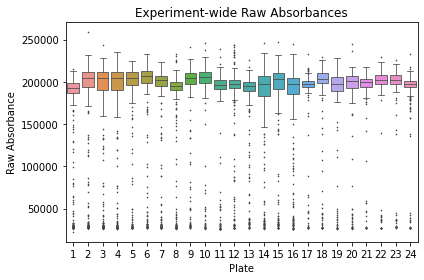

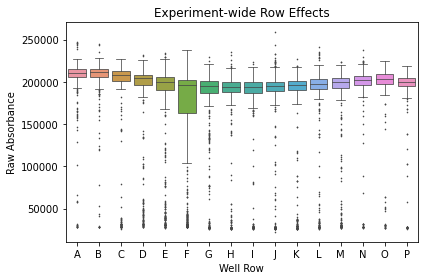

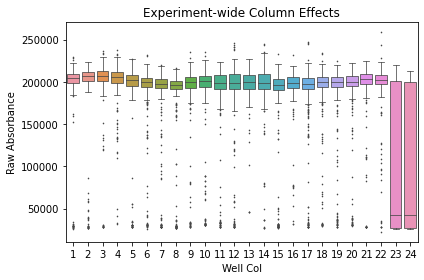

<Figure size 432x288 with 0 Axes>

In [21]:
# Function to plot boxplots
def plot_box(title, filename, x='Plate', y='Raw Absorbance', data=compiled_df):
    sns.boxplot(x=x, y=y, data=data, linewidth=0.75, fliersize=0.75)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(('Figures/' + filename + '.png'), dpi=DPI)
    plt.show()
    plt.clf()

# Plot boxplot all data, by plate
plot_box('Experiment-wide Raw Absorbances', 'experiment_wide_raw_absorbances')

# Plot experiment-wide row effects
plot_box('Experiment-wide Row Effects', 'experiment_wide_row_effect', x='Well Row')

# Plot experiment-wide column effects
plot_box('Experiment-wide Column Effects', 'experiment_wide_col_effect', x='Well Col')

## Control well variability
Bar plots of the positive and negative controls allow quick checking of the consistency of controls across the screen and
the relative differences between the controls.

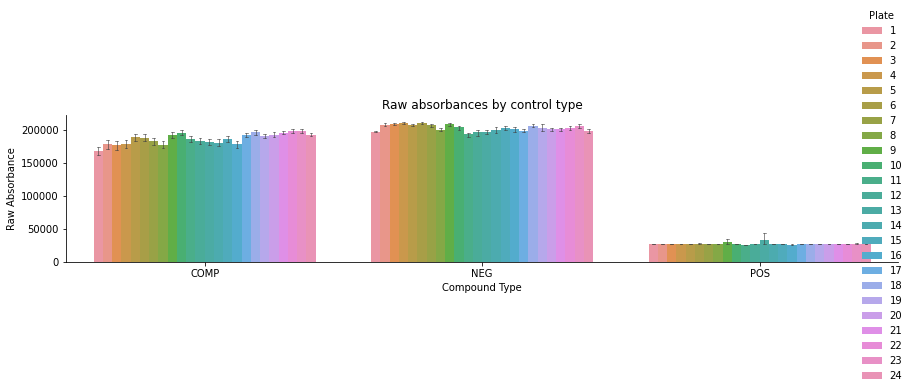

<Figure size 432x288 with 0 Axes>

In [22]:
sns.catplot(x='COMP_TYPE',
            y='Raw Absorbance',
            hue='Plate',
            data=compiled_df,
            kind='bar',
            height=3,
            aspect=4,
            capsize=.01,
            errwidth=0.6)
plt.xlabel('Compound Type')
plt.ylabel('Raw Absorbance')
plt.title('Raw absorbances by control type')
plt.tight_layout()
plt.savefig('Figures/raw_absorbances_by_control.png', dpi=DPI)
plt.show()
plt.clf()

## Dataset statistics
Quality control statistics for each plate can be generated based on the intra-plate controls.
To do this on a per-plate basis, the data is grouped by plate and compound type (e.g. negative control, positive control, or library compound).

Some basic statistics are calculated for each, including:
 - mean
 - standard deviation
 - median
 - median absolute deviation

The hierarchical index from the groupby function makes the DataFrame more difficult to work with, so it is flattened.
The column names are then in the format of statistic + compound type. (e.g. mean NEG)

In [23]:
# Generate DataFrame with control value stats, by plate
stats_df = compiled_df.groupby(['Plate', 'COMP_TYPE'])['Raw Absorbance'].agg(
    ['mean', 'std', 'median', 'mad']).unstack()
stats_df.columns = [' '.join(col).strip() for col in stats_df.columns.values]  # Flatten hierarchical index


#### Regression plot of controls
With basic descriptive statistics for the controls for each plate calculated, it is simple to visualise them.
This, with the aid of a regression model fit, allows us to easily assess if there is any drift in the assay absorbance readings as we progress through the plates.
This assessment assumes that all of the dataset originate from the same screen replicate.

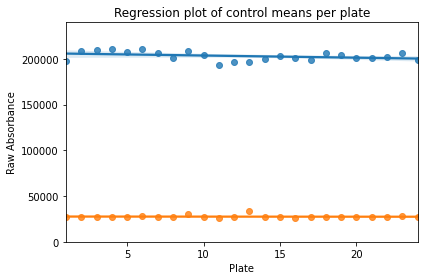

<Figure size 432x288 with 0 Axes>

In [24]:
fig, ax = plt.subplots()
sns.regplot(x=stats_df.index, y='mean NEG', data=stats_df, ax=ax)
sns.regplot(x=stats_df.index, y='mean POS', data=stats_df, ax=ax)
plt.ylim(0,240000)
plt.ylabel('Raw Absorbance')
plt.title('Regression plot of control means per plate')
plt.tight_layout()
plt.savefig('Figures/reg_plot_controls.png', dpi=DPI)
plt.show()
plt.clf()

#### Signal-to-background
The signal-to-background ratio is a weak parameter for high-throughput screening QC, but can easily be calculated as:

$$S/B = \frac{mean(C_{pos})}{mean(C_{neg})}$$

In [25]:
stats_df['signal_to_bg'] = (stats_df['mean NEG'] / stats_df['mean POS']).round(2)

#### Z' factor
The Z' factor is one of the most widely used QC metrics in HTS developed by Zhang *et al.* (1999), which takes in to account the range between positive and negative control distributions.
Values between 0.5 and 1 are excellent, values between 0 and 0.5 may be acceptable, and values less than 0 indicate the assay is unlikely to be usable in a HTS context.

Z' factor can be calculated as follows:

$$Z' = 1 - \frac{3 \times SD(C_{pos}) + 3 \times SD(C_{neg})}{\lvert mean(C_{pos}) - mean(C_{neg}) \rvert}$$


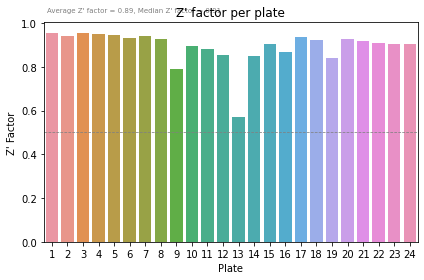

<Figure size 432x288 with 0 Axes>

In [26]:
# Calculate Z' score per plate
stats_df['Z_factor'] = (1 - (
        (3 * (stats_df['std POS'] + stats_df['std NEG'])) / (stats_df['mean NEG'] - stats_df['mean POS']))).round(3)

# Plot Z' score per plate
sns.barplot(x=stats_df.index, y='Z_factor', data=stats_df)
plt.ylabel("Z' Factor")
plt.axhline(y=0.5, color='#808080', linestyle='--', linewidth=0.75)
plt.title("Z' factor per plate")
plt.annotate(
    ("Average Z' factor = " + str(stats_df['Z_factor'].mean().round(2)) + ", Median Z' factor = " + str(
        stats_df['Z_factor'].median().round(2))),
    (-0.3, 1.05),
    fontsize='x-small',
    color='#808080',
    annotation_clip=False)
plt.tight_layout()
plt.savefig('Figures/Z_factor_bar.png', dpi=DPI)
plt.show()
plt.clf()

#### Robust Z' factor
The robust Z' factor is an alternative QC metric which is very similar to the normal Z' factor but is not affected by outliers within the dataset as it uses median absolute deviation (MAD) and median.
Robust Z' factor can be calculated as follows:

$$Z' = 1 - \frac{3 \times MAD(C_{pos}) + 3 \times MAD(C_{neg})}{\lvert median(C_{pos}) - median(C_{neg}) \rvert}$$


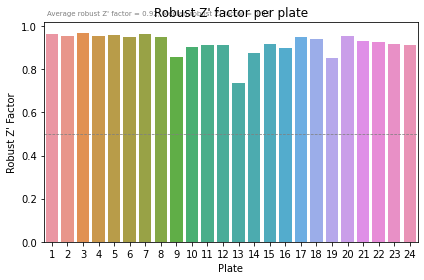

<Figure size 432x288 with 0 Axes>

In [27]:
# Calculate Z' score robust per plate
stats_df['Z_factor_robust'] = (1 - ((3 * (stats_df['mad POS'] + stats_df['mad NEG'])) / (
        stats_df['median NEG'] - stats_df['median POS']))).round(3)

# Plot Z' Robust per plate
sns.barplot(x=stats_df.index, y='Z_factor_robust', data=stats_df)
plt.ylabel("Robust Z' Factor")
plt.axhline(y=0.5, color='#808080', linestyle='--', linewidth=0.75)
plt.title("Robust Z' factor per plate")
plt.annotate(
    ("Average robust Z' factor = " + str(
        stats_df['Z_factor_robust'].mean().round(2)) + ", Median robust Z' factor = " + str(
        stats_df['Z_factor_robust'].median().round(2))),
    (-0.3, 1.05),
    fontsize='x-small',
    color='#808080',
    annotation_clip=False)
plt.tight_layout()
plt.savefig('Figures/Z_factor_robust_bar.png', dpi=DPI)
plt.show()
plt.clf()

In [28]:
# Export the per-plate statistics calculated to a CSV
stats_df.to_csv('experiment-stats.csv')

## Plate visualisation
Simple visualisation of plates is an effective technique for uncovering undesirable patterns that could be indicative of technical problems.
For example, identifying strong edge-effects which could adversely affect robust data interpretation.

Data must be reshaped to mimic its format in the plate from which it was derived, allowing for easy interpretation.

A function is defined to reshape the data into the appropriate format and then plot it into a heatmap.

In [59]:
def plate_heatmap(file):
    """
    Reshape given raw data file into a 384- or 96-well array and plot to heatmap.
    :param file: an integer value used to reference the files list
    :return: returns seaborn heatmap as png
    """

    global xticks, yticks
    plate = pd.read_csv(INPUT_DIRECTORY + '/' + files[file], skiprows=5)
    plate = plate.iloc[:, 3]

    # Create directory in figures to export heatmaps
    if not os.path.exists('Figures/Heatmaps/'):
        os.mkdir('Figures/Heatmaps')

    if plate.shape[0] == 384:
        plate_reshape = (16, 24)  # number of rows, number of columns for 384
        yticks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
        xticks = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                  '19', '20', '21', '22', '23', '24']
    elif plate.shape[0] == 96:
        plate_reshape = (8, 12)  # number of rows, number of columns for 96
        yticks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
        xticks = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    else:
        print(
            'Unknown plate format - cannot generate the heatmaps. Must be 384 or 96 well format, with no missing values')

    plate_view = plate.values.reshape(plate_reshape)

    sns.heatmap(plate_view,
                yticklabels=yticks,
                xticklabels=xticks,
                square=True,
                vmax=stats_df['median NEG'].median(),  # Normalise upper scale limit across all plates
                cmap='RdBu',
                cbar_kws={'label': 'Raw Absorbance'})
    plt.title('Plate ' + str(file + 1))
    plt.suptitle(str(files[file]))
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.tight_layout()
    plt.savefig('Figures/Heatmaps/heatmap_plate_' + str(file + 1) + '.png', dpi=DPI)
    plt.show()
    plt.clf()

The defined function can be used in a simple loop to iterate over each plate in the loaded dataset.

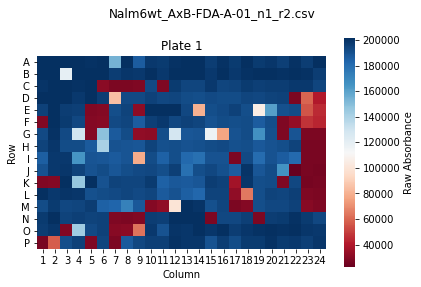

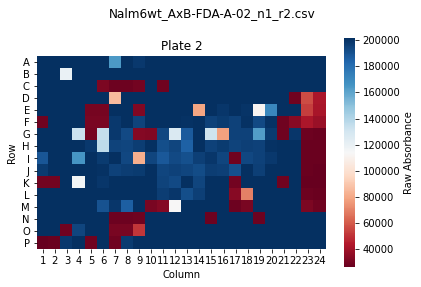

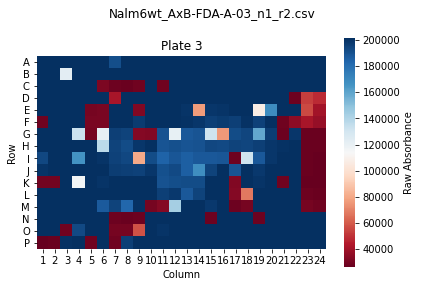

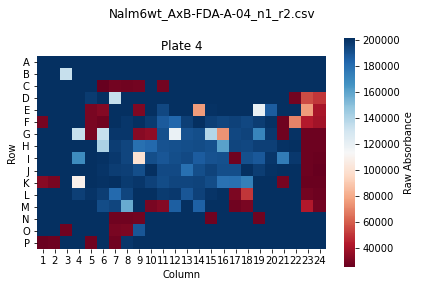

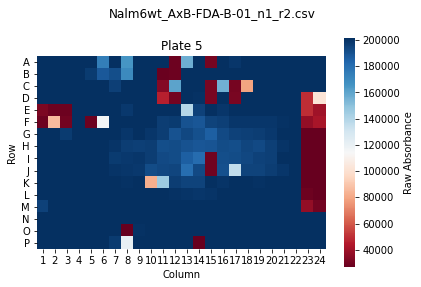

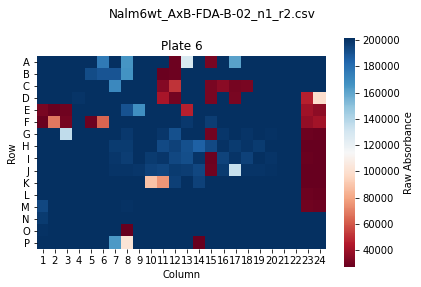

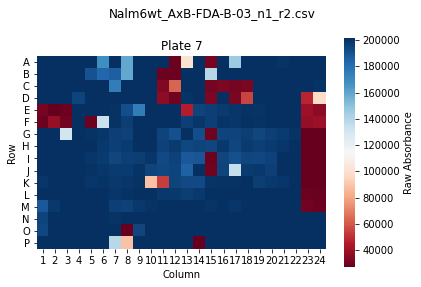

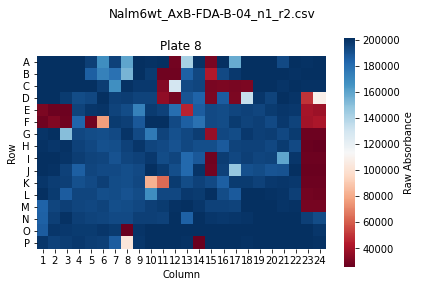

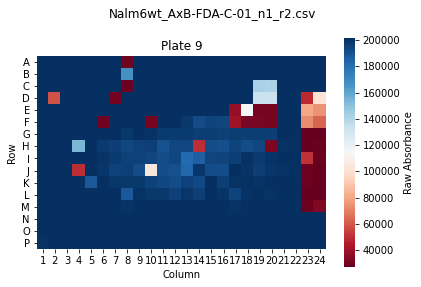

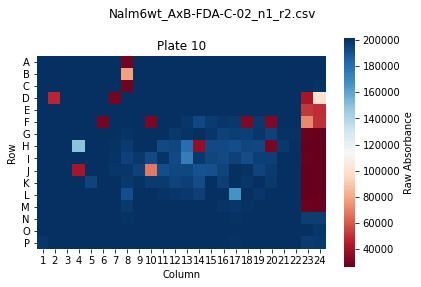

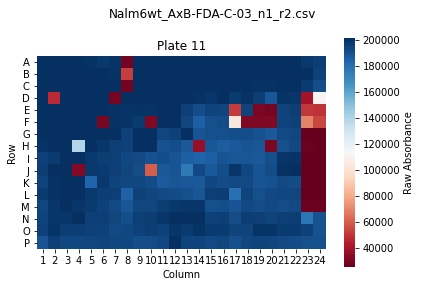

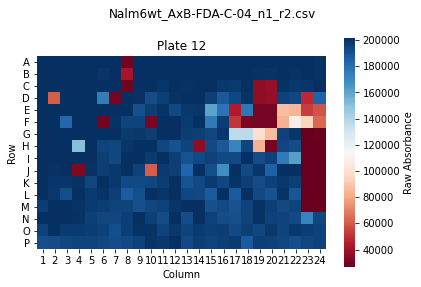

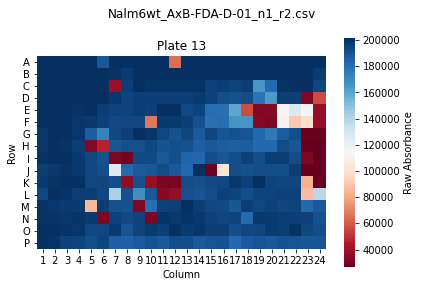

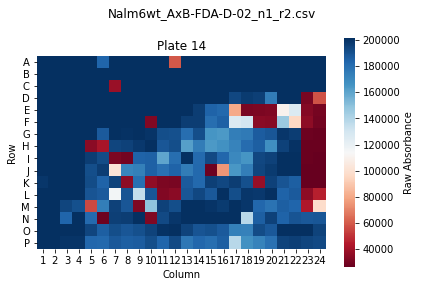

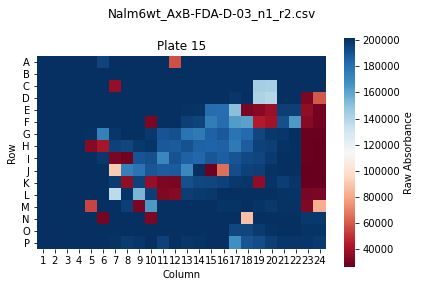

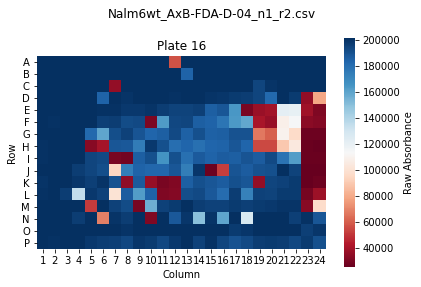

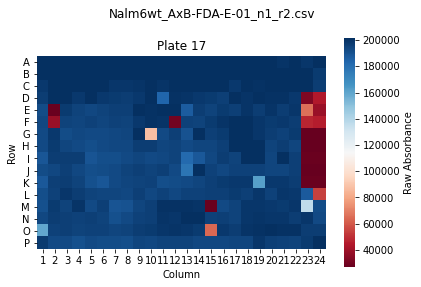

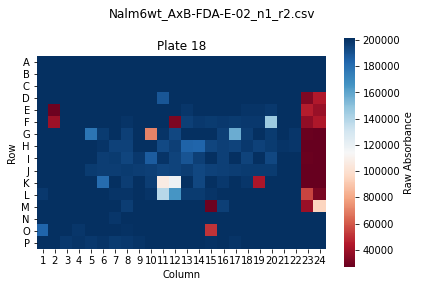

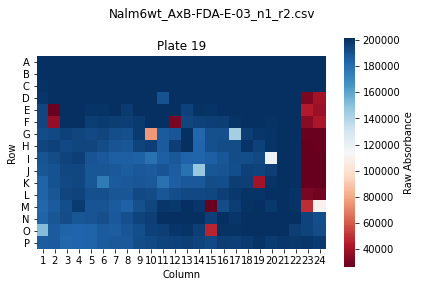

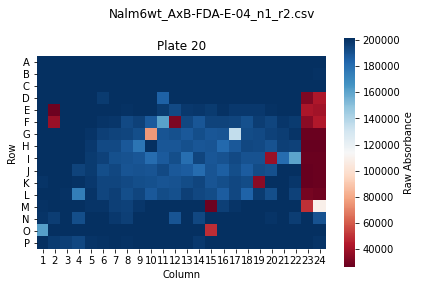

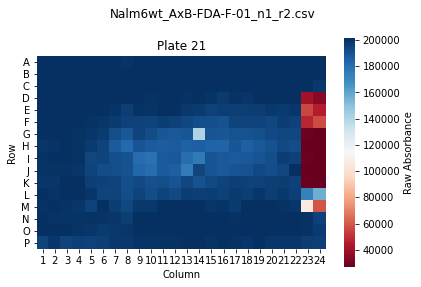

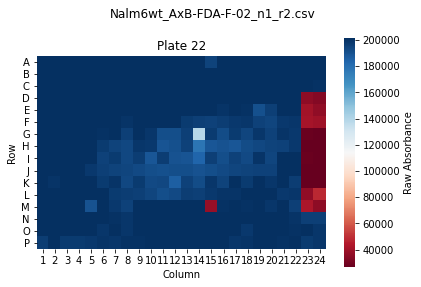

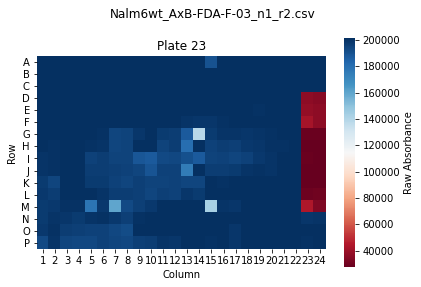

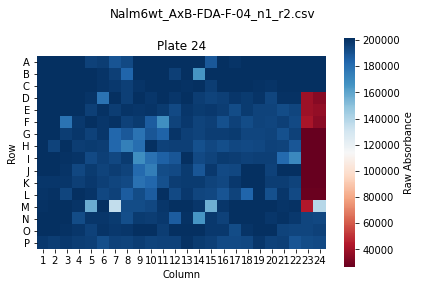

<Figure size 432x288 with 0 Axes>

In [60]:
for file in range(len(files)):
    plate_heatmap(file)

#### References
Zhang, Chung, & Oldenburg (1999) 'A simple statistical parameter for use in evaluation and validation of high throughput
screening assays' *J Biomol Screen* 4(2):67-73

